# FCOS Model Inference using PyTorch

FCOS model is available in [torchvision](https://pytorch.org/vision/main/models/fcos.html). Let us use the pre-trained model for image and video inference. 


In [ ]:
import torch
import numpy as np
import cv2
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import glob
import os
import time
import requests 
import zipfile

## Utils

Let us write different utils function that is needed for inference and visualization. 

Create a directory to save inference results.


In [ ]:
# Create result directory.
result_dir = 'results'
os.makedirs(result_dir, exist_ok=True)

Let's use GPU (Cuda) if available.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using {}.'.format(device))

Using cuda.


The pre-trained model is trained on the COCO dataset. The model predicts the class index. To map it to the class name, let us define the COCO class name list. 

In [ ]:
COCO_CLASSES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

After model inference, we need to plot the predicted bounding box. It is better to use different colors for different classes. So let us generate it. 


In [ ]:
# Create different colors for each class.
np.random.seed(42)
COLORS = np.random.uniform(0, 255, size=(len(COCO_CLASSES), 3))

Here is a function that downloads FCOS (fcos_resnet50_fpn) model weight using torchvision, loads it, and returns it in eval mood.

In [ ]:
# Function to load the model.
def get_model(device):
    # Load the model.
    model = torchvision.models.detection.fcos_resnet50_fpn(
        weights='DEFAULT'
    )
    # Load the model onto the computation device.
    model = model.eval().to(device)
    return model

Before inference, the input images need to have some standard transform. Here, it is the most basic you can imagine. You only have to transform to tensor. 


In [ ]:
# Define the torchvision image transforms.
transform = transforms.Compose([
    transforms.ToTensor()
])

Here is a function to visualize four images in a 2 x 2 grid. 

In [ ]:
# Plot and visualize images in a 2x2 grid.
def visualize(result_dir):
    """
    Function accepts a list of images and plots
    them in a 2x2 grid.
    """
    plt.figure(figsize=(20, 18))
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))
    for i, image_name in enumerate(image_names):
        image = plt.imread(image_name)
        plt.subplot(2, 2, i+1)
        plt.imshow(image)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

## Download Data

Let us write functions for downloading and unzipping data. 


In [ ]:
def download_file(url, save_name):
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)
        
download_file(
    'https://www.dropbox.com/s/ukc7wocsn7xrm2r/data.zip?dl=1',
    'data.zip'
)

In [ ]:
# Unzip the data file
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

unzip('data.zip')

Extracted all


## Prediction Function

Let us write a function for inference. It takes images, the model, which device to use (GPU or CPU), and the bounding box threshold. And it returns bounding boxes co-ordinates, class names, and the class index. 

In [ ]:
def predict(image, model, device, detection_threshold):
    """
    Predict the output of an image after forward pass through
    the model and return the bounding boxes, class names, and 
    class labels. 
    """
    # Transform the image to tensor.
    image = transform(image).to(device)
    # Add a batch dimension.
    image = image.unsqueeze(0) 
    # Get the predictions on the image.
    with torch.no_grad():
        outputs = model(image) 

    # Get score for all the predicted objects.
    pred_scores = outputs[0]['scores'].detach().cpu().numpy()

    # Get all the predicted bounding boxes.
    pred_bboxes = outputs[0]['boxes'].detach().cpu().numpy()
    # Get boxes above the threshold score.
    boxes = pred_bboxes[pred_scores >= detection_threshold].astype(np.int32)
    labels = outputs[0]['labels'][pred_scores >= detection_threshold]
    # Get all the predicited class names.
    pred_classes = [COCO_CLASSES[i] for i in labels.cpu().numpy()]

    return boxes, pred_classes, labels

## Annotation Functions

Here is a function that takes bounding boxes, their class name, class index, and the inferred image and returns annotated image. 


In [ ]:
def draw_boxes(boxes, classes, labels, image):
    """
    Draws the bounding box around a detected object.
    """
    lw = max(round(sum(image.shape) / 2 * 0.003), 2) # Line width.
    tf = max(lw - 1, 1) # Font thickness.
    
    for i, box in enumerate(boxes):
        p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
        color = COLORS[labels[i]]
        class_name = classes[i]
        cv2.rectangle(
            image,
            p1,
            p2,
            color[::-1],
            thickness=lw,
            lineType=cv2.LINE_AA
        )
        # For filled rectangle.
        w, h = cv2.getTextSize(
            class_name, 
            0, 
            fontScale=lw / 3, 
            thickness=tf
        )[0]  # Text width, height
        
        outside = p1[1] - h >= 3
        p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
        
        cv2.rectangle(
            image, 
            p1, 
            p2, 
            color=color[::-1], 
            thickness=-1, 
            lineType=cv2.LINE_AA
        )  
        cv2.putText(
            image, 
            class_name, 
            (p1[0], p1[1] - 5 if outside else p1[1] + h + 2),
            cv2.FONT_HERSHEY_SIMPLEX, 
            fontScale=lw / 3.8, 
            color=(255, 255, 255), 
            thickness=tf, 
            lineType=cv2.LINE_AA
        )
    return image

## Inference on Images

Now, we have the required utils. Now, let's make inferences. 

Get the model. 

In [ ]:
model = get_model(device)

Downloading: "https://download.pytorch.org/models/fcos_resnet50_fpn_coco-99b0c9b7.pth" to /root/.cache/torch/hub/checkpoints/fcos_resnet50_fpn_coco-99b0c9b7.pth


  0%|          | 0.00/124M [00:00<?, ?B/s]

Make inferences and plot bounding boxes and their class name on the image. 

In [ ]:
# Get all the image paths.
image_paths = glob.glob(os.path.join('data', '*.jpg'))

# Run inference on all images.
for image_path in image_paths:
    # Read the image.
    image = cv2.imread(image_path)
    # Create a BGR copy of the image for annotation.
    image_bgr = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    # Detect outputs.
    boxes, classes, labels = predict(
        image, 
        model, 
        device, 
        detection_threshold=0.5
    )
    # Draw bounding boxes.
    image = draw_boxes(boxes, classes, labels, image_bgr)
    save_name = image_path.split(os.path.sep)[-1]
    cv2.imwrite(os.path.join(result_dir, save_name), image[:, :, ::-1])

Finally, visualize the results. 

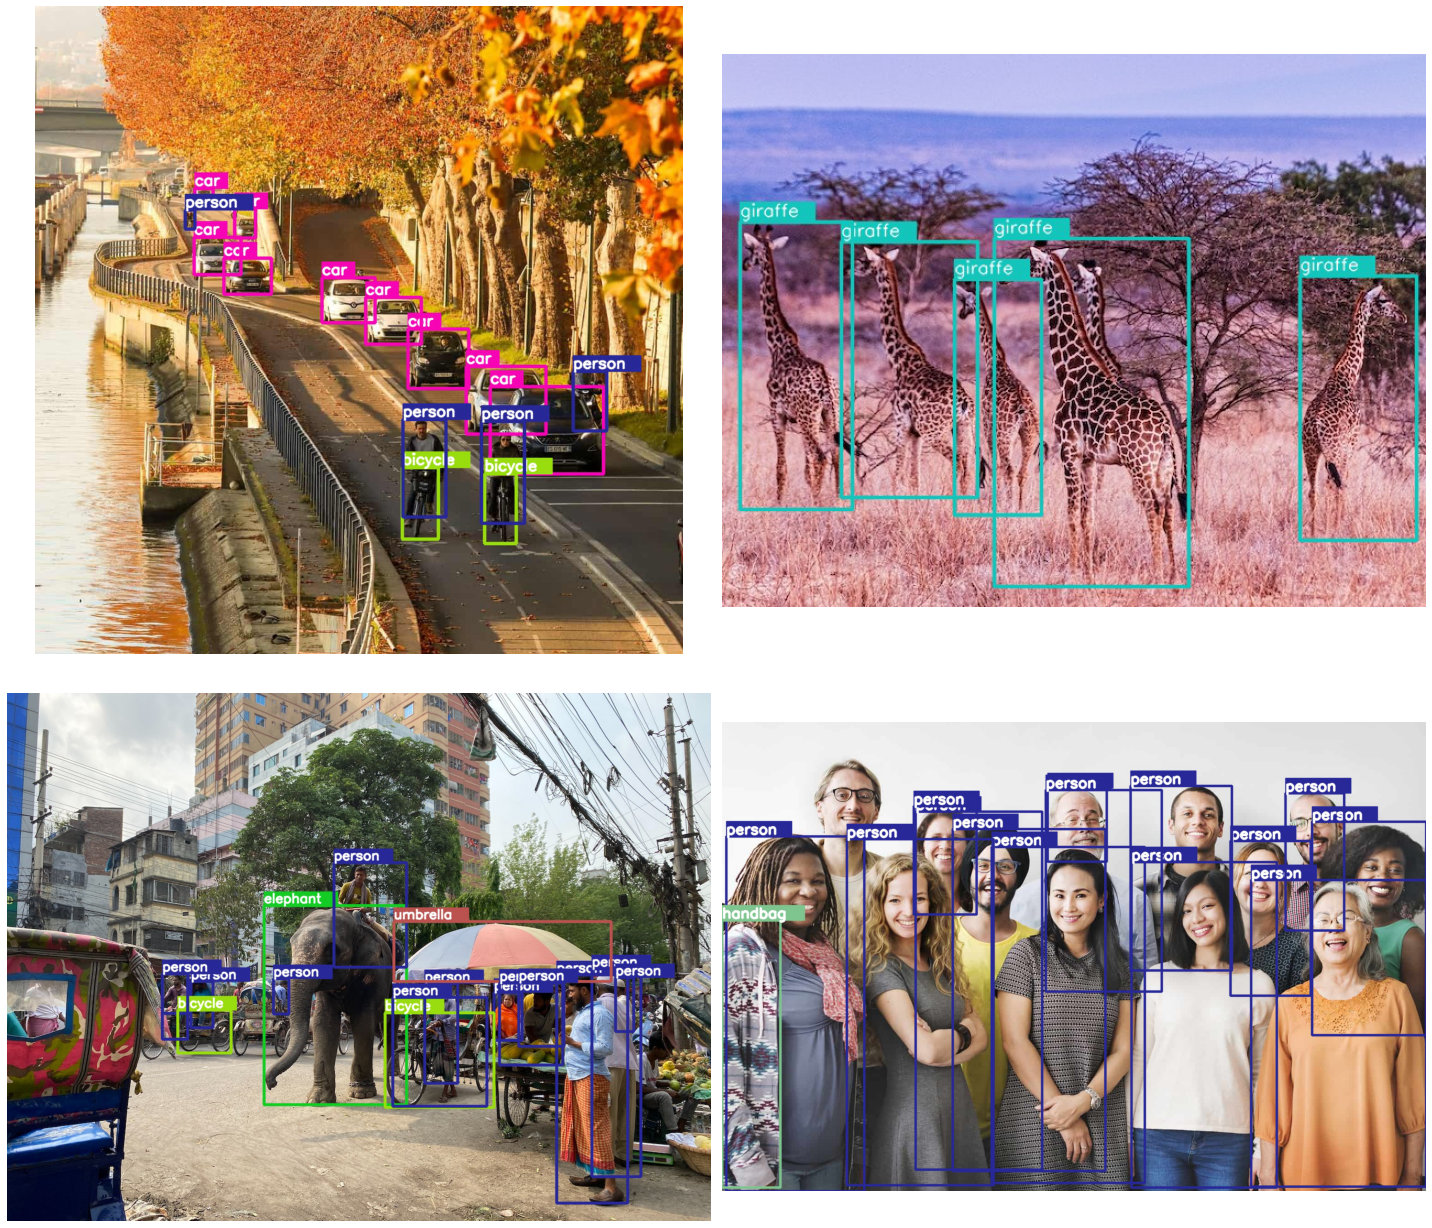

In [ ]:
# Visualize
visualize(result_dir)

## Inference on Videos

Let's make inferences from the model on videos. 

It will load the video, make inferences on each frame, add detection, and save it back to the video. 

In [ ]:
# Get all the video paths.
video_paths = glob.glob(os.path.join('data', '*.mp4'))

In [ ]:
for video_path in video_paths:
    print(f"Running inference on video: {video_path}")
    cap = cv2.VideoCapture(video_path)

    if (cap.isOpened() == False):
        print('Error while trying to read video. Please check path again')

    # Get the frame width and height.
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))

    save_name = video_path.split(os.path.sep)[-1]
    # Define codec and create VideoWriter object .
    out = cv2.VideoWriter(os.path.join(result_dir, save_name), 
                          cv2.VideoWriter_fourcc(*'mp4v'), 
                          30, 
                          (frame_width, frame_height))

    frame_count = 0 # To count total frames.
    total_fps = 0 # To get the final frames per second.
    
    # Read until end of video.
    while(cap.isOpened):
        # Capture each frame of the video.
        ret, frame = cap.read()
        if ret:
            frame_copy = frame.copy()
            frame_copy = cv2.cvtColor(frame_copy, cv2.COLOR_BGR2RGB)
            # Get the start time.
            start_time = time.time()
            # Get predictions for the current frame.
            boxes, classes, labels = predict(
                frame, 
                model, 
                device, 
                detection_threshold=0.5
            )

            # Draw boxes and show current frame on screen.
            image = draw_boxes(boxes, classes, labels, frame)

            # Get the end time.
            end_time = time.time()
            # Get the fps.
            fps = 1 / (end_time - start_time)
            # Add fps to total fps.
            total_fps += fps
            # Increment frame count.
            frame_count += 1
            if frame_count % 100 == 0:
                print(f"Frame: {frame_count}   ::   FPS: {fps:.1f}")
            # Write the FPS on the current frame.
            cv2.putText(image, f"{fps:.3f} FPS", (15, 30), cv2.FONT_HERSHEY_SIMPLEX,
                        1, (0, 255, 0), 2)
            # Convert from BGR to RGB color format.
#             cv2.imshow('image', image)
            out.write(image)
            # Press `q` to exit.
#             if cv2.waitKey(1) & 0xFF == ord('q'):
#                 break

        else:
            break

    # Release VideoCapture().
    cap.release()
    # Close all frames and video windows.
    cv2.destroyAllWindows()

    # Calculate and print the average FPS.
    avg_fps = total_fps / frame_count
    print(f"Average FPS: {avg_fps:.3f}\n\n")

Running inference on video: data/soccer.mp4
Frame: 100   ::   FPS: 8.8
Frame: 200   ::   FPS: 8.4
Frame: 300   ::   FPS: 8.8
Average FPS: 8.929


Running inference on video: data/horses_video.mp4
Frame: 100   ::   FPS: 8.8
Frame: 200   ::   FPS: 9.3
Average FPS: 8.748


Running inference on video: data/traffic_video.mp4
Frame: 100   ::   FPS: 7.6
Frame: 200   ::   FPS: 7.3
Frame: 300   ::   FPS: 7.3
Frame: 400   ::   FPS: 7.2
Frame: 500   ::   FPS: 7.4
Frame: 600   ::   FPS: 7.4
Frame: 700   ::   FPS: 7.4
Frame: 800   ::   FPS: 7.5
Frame: 900   ::   FPS: 7.5
Frame: 1000   ::   FPS: 7.3
Frame: 1100   ::   FPS: 7.3
Frame: 1200   ::   FPS: 7.4
Average FPS: 7.433


Running inference on video: data/cowboy.mp4
Frame: 100   ::   FPS: 7.3
Frame: 200   ::   FPS: 7.3
Frame: 300   ::   FPS: 7.5
Frame: 400   ::   FPS: 7.2
Frame: 500   ::   FPS: 7.3
Frame: 600   ::   FPS: 7.4
Frame: 700   ::   FPS: 7.5
Average FPS: 7.393




## References

- [FCOS TorchVision](https://pytorch.org/vision/main/models/fcos.html)